In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# load
with open('bigVocabCountVec_trained_PCA_2021-07-12.pickle', 'rb') as f:
    pca = pickle.load(f)
with open('bigVocabCountVec_trained_TLDA_2021-07-12.pickle', 'rb') as f:
    tlda = pickle.load(f)
id_map = np.load('bigVocabCountVec_id-word-map_2021-07-12.npy')

In [3]:
tlda.factors_.shape

(20, 20)

In [4]:
# id_map

In [5]:
# extract topics and correct weights
probs = np.array(pca.reverse_transform(tlda.factors_))
total_topics = probs.shape[0]

probmaps = []
for i in range(total_topics):
    topids = probs[i,:].argsort()[-20:]
    probmaps.append({id_map[word_id]: probs[i,word_id] for word_id in topids})

In [15]:
probmaps

[{'covid coronavirus': 4.00704338713743e-06,
  'coronavirus covid': 4.310416156499694e-06,
  'infect': 4.316206549736672e-06,
  'death': 4.826358654170616e-06,
  'wuhan': 4.844459470025813e-06,
  'home': 5.067337818100372e-06,
  'spread': 5.3151048020830935e-06,
  'countri': 5.62193438088263e-06,
  'die': 5.793696548859411e-06,
  'world': 1.0424272627419918e-05,
  'health': 1.1088047579076105e-05,
  'work': 1.1700504278161878e-05,
  'like': 1.3461201308377542e-05,
  'say': 2.0036265606474754e-05,
  'time': 2.5547893585464383e-05,
  'virus': 3.1058100549445465e-05,
  'peopl': 3.2551850386143184e-05,
  'china': 3.4256721663344174e-05,
  'covid': 3.4365888299781795e-05,
  'coronavirus': 3.620950424372029e-05},
 {'stupid': 1.4800528341641698e-06,
  'want': 1.5322820894833772e-06,
  'peopl die': 1.5838339826421363e-06,
  'fuck': 1.7167126587365008e-06,
  'care': 1.9246019152103145e-06,
  'time http': 1.972056991734119e-06,
  'test posit': 2.040786705651368e-06,
  'kill': 2.8271324005083233e

In [14]:
sorted(probs[0,:])[-20:]

[4.00704338713743e-06,
 4.310416156499694e-06,
 4.316206549736672e-06,
 4.826358654170616e-06,
 4.844459470025813e-06,
 5.067337818100372e-06,
 5.3151048020830935e-06,
 5.62193438088263e-06,
 5.793696548859411e-06,
 1.0424272627419918e-05,
 1.1088047579076105e-05,
 1.1700504278161878e-05,
 1.3461201308377542e-05,
 2.0036265606474754e-05,
 2.5547893585464383e-05,
 3.1058100549445465e-05,
 3.2551850386143184e-05,
 3.4256721663344174e-05,
 3.4365888299781795e-05,
 3.620950424372029e-05]

In [6]:
# sorted(probmaps[0].items(), key=lambda x: x[1])
sorted(probs[0])[:20]

[-4.0318573389598174e-05,
 -2.4007593995514893e-05,
 -1.773953764232778e-05,
 -7.571755167798341e-06,
 -6.274048635215358e-06,
 -5.879582491892513e-06,
 -4.740881155835064e-06,
 -4.438416187552024e-06,
 -3.7368754331867444e-06,
 -3.2886518193371977e-06,
 -2.9491822469286317e-06,
 -2.318129201086647e-06,
 -2.1202922956188422e-06,
 -1.9304939680635136e-06,
 -1.8445014019081548e-06,
 -1.7177349944606353e-06,
 -1.4063349647582323e-06,
 -1.3726100287161475e-06,
 -1.3640070252180593e-06,
 -1.2699923887732797e-06]

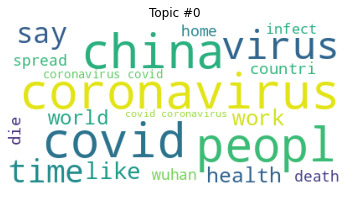

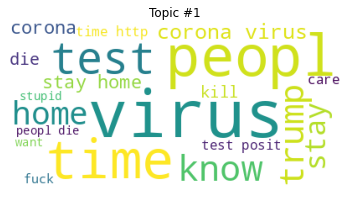

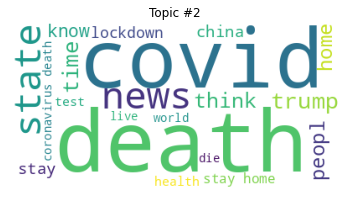

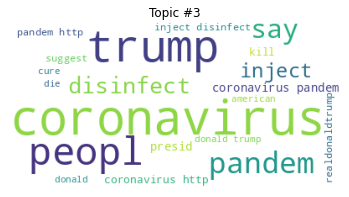

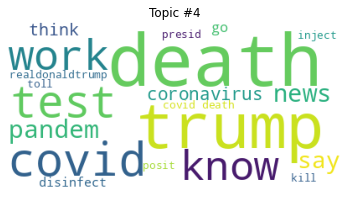

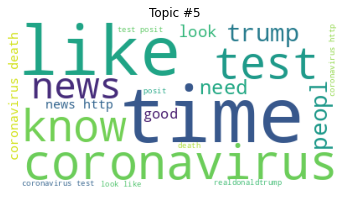

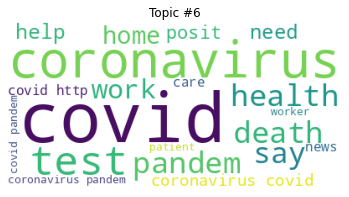

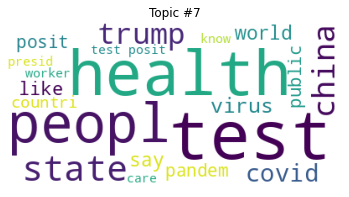

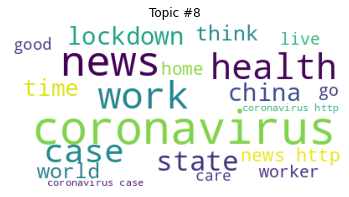

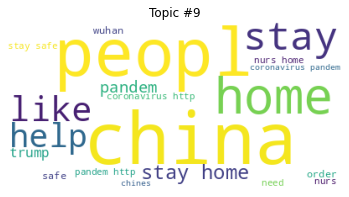

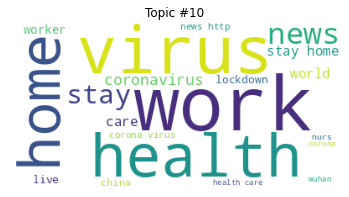

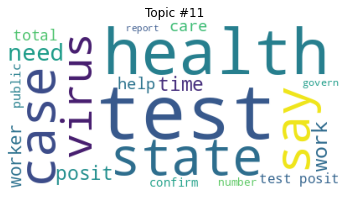

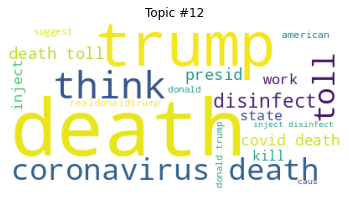

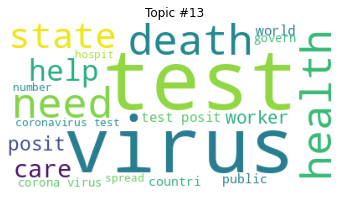

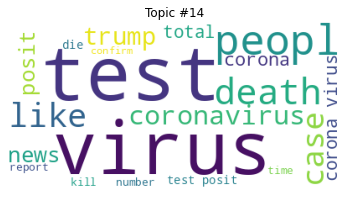

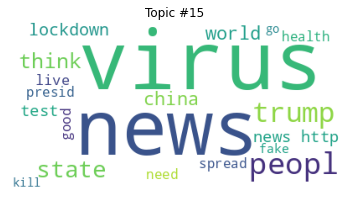

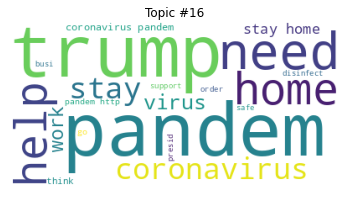

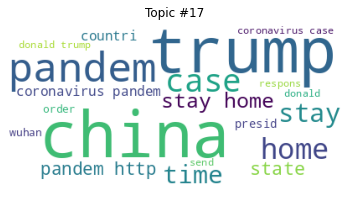

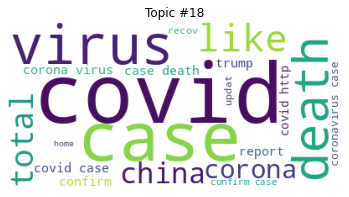

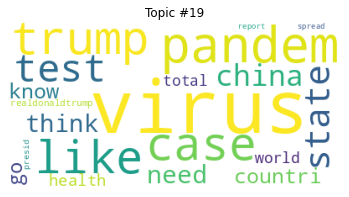

In [7]:
# draw word clouds
# fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for t in range(total_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(probmaps[t]))
    plt.axis("off")
    plt.title("Topic #" + str(t))

In [8]:
# plot toxicity rating(?) of each topic... there's no easily accessible hate speech lexicon!!!!